In [1]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
from dotenv import load_dotenv

import numpy as np
import time
import datetime
#import sqlite3    

In [2]:
# Load environment variables
load_dotenv()
#symbol = 'BTC/USD'
# period = '1d'

# Import environment variables
kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")
kraken = ccxt.kraken({"apiKey": kraken_public_key, "secret": kraken_secret_key})

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public_key)}")
print(f"Kraken secren data type: {type(kraken_secret_key)}")

Kraken key data type: <class 'str'>
Kraken secren data type: <class 'str'>


In [3]:
# function to pull crypto data
def fetch_crypto_data(crypto, interval, limit):
    interval_in_min = {'1m':1,'5m':5, '30m':30, '1h':60, '1d':1440, '1w':10080}
    no_of_data = limit * interval_in_min[interval]
    print(no_of_data)
    past_datetime = (datetime.datetime.now() + datetime.timedelta(minutes=240-no_of_data)).strftime('%Y-%m-%d %H:%M:%S')
    data = kraken.fetch_ohlcv(crypto, interval, kraken.parse8601(past_datetime))
    time.sleep(1)
    return data

In [4]:
data = fetch_crypto_data('ETH/USD', '1d', 720)
df_kraken = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
#df_kraken['date'] = pd.to_datetime(df_kraken['date'],unit='ms')

# Set index as datetime object and drop extraneous columns
df_kraken.set_index(pd.to_datetime(df_kraken['Date'], unit='ms', infer_datetime_format=True), inplace=True)
df_kraken.drop(columns=['Date'], inplace=True)


1036800


In [5]:
df_kraken

,Open,High,Low,Close,Volume
Date,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241
2019-03-28,139.02,139.24,136.75,137.35,13222.478652
2019-03-29,137.35,143.00,136.87,142.71,27335.951007
2019-03-30,142.74,145.49,139.63,142.01,25780.580602
2019-03-31,142.11,142.14,140.13,141.29,7464.446089
...,...,...,...,...,...
2021-03-11,1795.44,1847.73,1724.65,1826.87,71185.384072
2021-03-12,1826.92,1840.64,1722.02,1767.06,60538.007946
2021-03-13,1767.77,1942.71,1727.70,1920.17,85219.275813


In [6]:
# Drop NAs and calculate daily percent return
df_kraken['daily_return'] = df_kraken['Close'].dropna().pct_change()
df_kraken

,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241,NaN
2019-03-28,139.02,139.24,136.75,137.35,13222.478652,-0.012936
2019-03-29,137.35,143.00,136.87,142.71,27335.951007,0.039024
2019-03-30,142.74,145.49,139.63,142.01,25780.580602,-0.004905
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,-0.005070
...,...,...,...,...,...,...
2021-03-11,1795.44,1847.73,1724.65,1826.87,71185.384072,0.017307
2021-03-12,1826.92,1840.64,1722.02,1767.06,60538.007946,-0.032739
2021-03-13,1767.77,1942.71,1727.70,1920.17,85219.275813,0.086647


In [7]:
# Set short and long windows
short_window = 5
long_window = 20

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_close'] = df_kraken['Close'].ewm(halflife=short_window).mean()
df_kraken['slow_close'] = df_kraken['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df_kraken['crossover_long'] = np.where(df_kraken['fast_close'] > df_kraken['slow_close'], 1.0, 0.0)
df_kraken['crossover_short'] = np.where(df_kraken['fast_close'] < df_kraken['slow_close'], -1.0, 0.0)
df_kraken['crossover_signal'] = df_kraken['crossover_long'] + df_kraken['crossover_short']

df_kraken.head()

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241,NaN,139.150000,139.150000,0.0,0.0,0.0
2019-03-28,139.02,139.24,136.75,137.35,13222.478652,-0.012936,138.187716,138.234406,0.0,-1.0,-1.0
2019-03-29,137.35,143.00,136.87,142.71,27335.951007,0.039024,139.908257,139.778263,1.0,0.0,1.0
2019-03-30,142.74,145.49,139.63,142.01,25780.580602,-0.004905,140.547441,140.365528,1.0,0.0,1.0
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,-0.005070,140.739689,140.563455,1.0,0.0,1.0


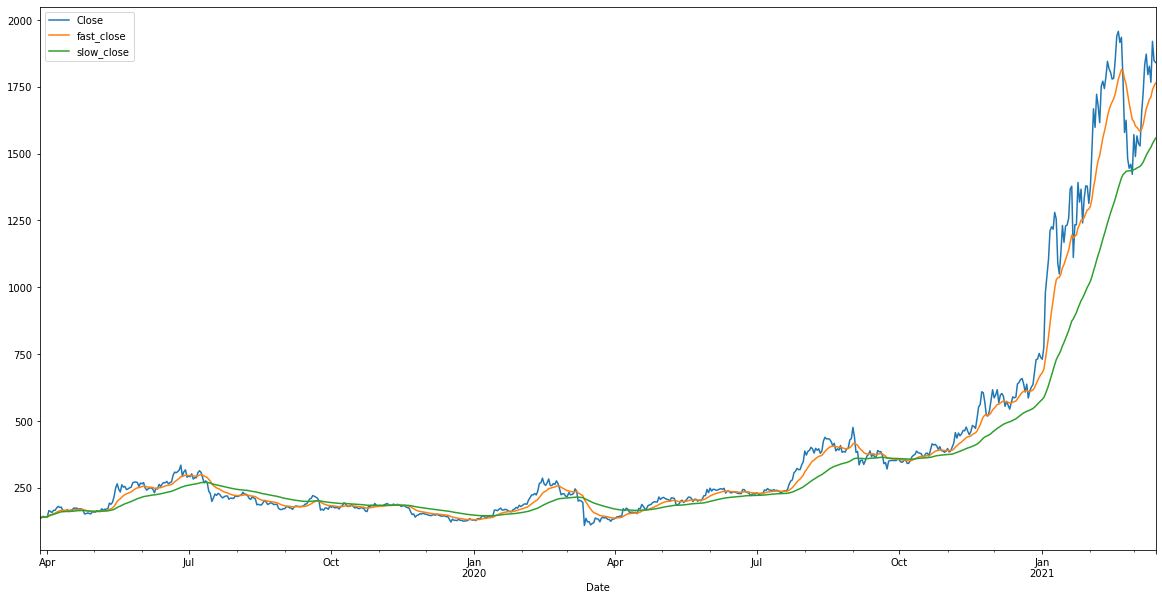

In [8]:
# Plot the EMA of ETH/USD closing prices
df_kraken[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [9]:
# Set short and long volatility windows
short_vol_window = 5
long_vol_window = 25

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_vol'] = df_kraken['daily_return'].ewm(halflife=short_vol_window).std()
df_kraken['slow_vol'] = df_kraken['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
df_kraken['vol_trend_long'] = np.where(df_kraken['fast_vol'] < df_kraken['slow_vol'], 1.0, 0.0)
df_kraken['vol_trend_short'] = np.where(df_kraken['fast_vol'] > df_kraken['slow_vol'], -1.0, 0.0) 
df_kraken['vol_trend_signal'] = df_kraken['vol_trend_long'] + df_kraken['vol_trend_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241,NaN,139.150000,139.150000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2019-03-28,139.02,139.24,136.75,137.35,13222.478652,-0.012936,138.187716,138.234406,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2019-03-29,137.35,143.00,136.87,142.71,27335.951007,0.039024,139.908257,139.778263,1.0,0.0,1.0,0.036741,0.036741,1.0,0.0,1.0
2019-03-30,142.74,145.49,139.63,142.01,25780.580602,-0.004905,140.547441,140.365528,1.0,0.0,1.0,0.027695,0.027909,1.0,0.0,1.0
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,-0.005070,140.739689,140.563455,1.0,0.0,1.0,0.022780,0.023458,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11,1795.44,1847.73,1724.65,1826.87,71185.384072,0.017307,1703.332047,1515.205237,1.0,0.0,1.0,0.048151,0.057329,1.0,0.0,1.0
2021-03-12,1826.92,1840.64,1722.02,1767.06,60538.007946,-0.032739,1711.581594,1523.784335,1.0,0.0,1.0,0.047566,0.056980,1.0,0.0,1.0
2021-03-13,1767.77,1942.71,1727.70,1920.17,85219.275813,0.086647,1738.583246,1537.286686,1.0,0.0,1.0,0.052442,0.057619,1.0,0.0,1.0


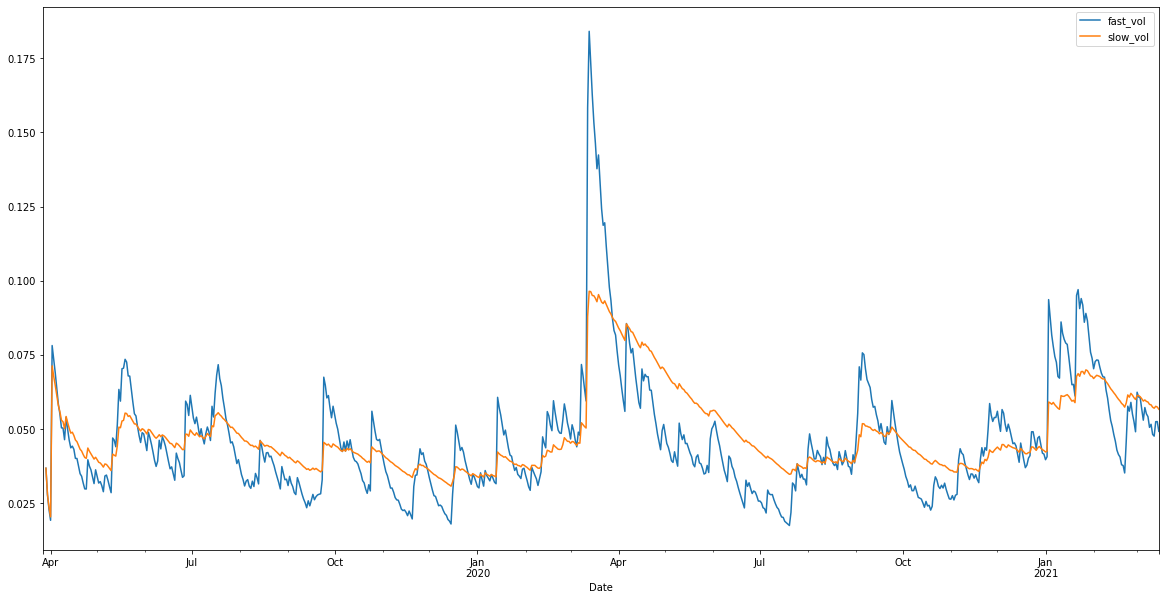

In [11]:
# Plot the EMA of BTC/USD daily return volatility
df_kraken[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [12]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df_kraken['bollinger_mid_band'] = df_kraken['Close'].rolling(window=bollinger_window).mean()
df_kraken['bollinger_std'] = df_kraken['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df_kraken['bollinger_upper_band']  = df_kraken['bollinger_mid_band'] + (df_kraken['bollinger_std'] * 1)
df_kraken['bollinger_lower_band']  = df_kraken['bollinger_mid_band'] - (df_kraken['bollinger_std'] * 1)

# Calculate bollinger band trading signal
df_kraken['bollinger_long'] = np.where(df_kraken['Close'] < df_kraken['bollinger_lower_band'], 1.0, 0.0)
df_kraken['bollinger_short'] = np.where(df_kraken['Close'] > df_kraken['bollinger_upper_band'], -1.0, 0.0)
df_kraken['bollinger_signal'] = df_kraken['bollinger_long'] + df_kraken['bollinger_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241,NaN,139.150000,139.150000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-28,139.02,139.24,136.75,137.35,13222.478652,-0.012936,138.187716,138.234406,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-29,137.35,143.00,136.87,142.71,27335.951007,0.039024,139.908257,139.778263,1.0,0.0,1.0,0.036741,0.036741,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-30,142.74,145.49,139.63,142.01,25780.580602,-0.004905,140.547441,140.365528,1.0,0.0,1.0,0.027695,0.027909,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,-0.005070,140.739689,140.563455,1.0,0.0,1.0,0.022780,0.023458,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11,1795.44,1847.73,1724.65,1826.87,71185.384072,0.017307,1703.332047,1515.205237,1.0,0.0,1.0,0.048151,0.057329,1.0,0.0,1.0,1652.1955,168.657667,1820.853167,1483.537833,0.0,-1.0,-1.0
2021-03-12,1826.92,1840.64,1722.02,1767.06,60538.007946,-0.032739,1711.581594,1523.784335,1.0,0.0,1.0,0.047566,0.056980,1.0,0.0,1.0,1644.7480,159.431427,1804.179427,1485.316573,0.0,0.0,0.0
2021-03-13,1767.77,1942.71,1727.70,1920.17,85219.275813,0.086647,1738.583246,1537.286686,1.0,0.0,1.0,0.052442,0.057619,1.0,0.0,1.0,1643.9845,157.996169,1801.980669,1485.988331,0.0,-1.0,-1.0


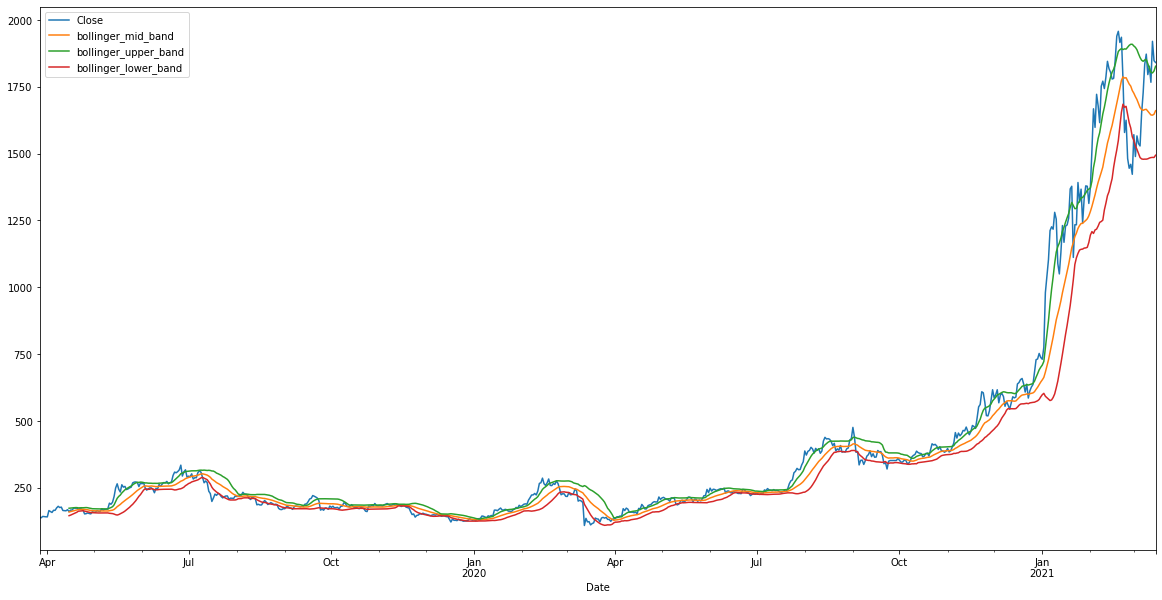

In [13]:
# Plot the Bollinger Bands for BTC/USD closing prices
df_kraken[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [14]:
df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-27,133.29,139.80,133.13,139.15,31417.824241,NaN,139.150000,139.150000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-28,139.02,139.24,136.75,137.35,13222.478652,-0.012936,138.187716,138.234406,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-29,137.35,143.00,136.87,142.71,27335.951007,0.039024,139.908257,139.778263,1.0,0.0,1.0,0.036741,0.036741,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-30,142.74,145.49,139.63,142.01,25780.580602,-0.004905,140.547441,140.365528,1.0,0.0,1.0,0.027695,0.027909,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,-0.005070,140.739689,140.563455,1.0,0.0,1.0,0.022780,0.023458,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11,1795.44,1847.73,1724.65,1826.87,71185.384072,0.017307,1703.332047,1515.205237,1.0,0.0,1.0,0.048151,0.057329,1.0,0.0,1.0,1652.1955,168.657667,1820.853167,1483.537833,0.0,-1.0,-1.0
2021-03-12,1826.92,1840.64,1722.02,1767.06,60538.007946,-0.032739,1711.581594,1523.784335,1.0,0.0,1.0,0.047566,0.056980,1.0,0.0,1.0,1644.7480,159.431427,1804.179427,1485.316573,0.0,0.0,0.0
2021-03-13,1767.77,1942.71,1727.70,1920.17,85219.275813,0.086647,1738.583246,1537.286686,1.0,0.0,1.0,0.052442,0.057619,1.0,0.0,1.0,1643.9845,157.996169,1801.980669,1485.988331,0.0,-1.0,-1.0


In [17]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']
df_kraken[x_var_list] = df_kraken[x_var_list].shift(1)
df_kraken[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-03-11,1.0,1.0,0.0
2021-03-12,1.0,1.0,-1.0
2021-03-13,1.0,1.0,0.0
2021-03-14,1.0,1.0,-1.0
2021-03-15,1.0,1.0,-1.0


In [20]:
df_kraken.dropna(subset=x_var_list, inplace=True)
df_kraken.dropna(subset=['daily_return'], inplace=True)
df_kraken = df_kraken.replace([np.inf, -np.inf], np.nan)
df_kraken['Positive Return'] = np.where(df_kraken['daily_return'] > 0, 1.0, 0.0)


In [28]:
# Construct training start and end dates
training_start = df_kraken.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-20'

# Construct testing start and end dates
testing_start =  '2020-08-21'
testing_end = df_kraken.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_kraken[x_var_list][training_start:training_end]
y_train = df_kraken['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_kraken[x_var_list][testing_start:testing_end]
y_test = df_kraken['Positive Return'][testing_start:testing_end]

Training Start: 2019-03-28
Training End: 2020-08-20
Testing Start: 2020-08-21
Testing End: 2021-03-15


In [42]:
df_kraken.to_csv('kraken_pull_EthExample.csv')